In [34]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
import cv2
import scipy
from skimage.feature import peak_local_max
from torchvision import transforms
import pickle
from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import solve_ivp
device = torch.device('cpu')

In [35]:
def diffeq(t, x):
    x0 = torch.tensor(x).clone().detach()

    x1 = x0.clone().detach()
    x1.requires_grad = True
    f1 = F1(x1,p)
    f1.backward()
    grad1 = x1.grad

    x2 = x0.clone().detach()
    x2 = x2 + torch.tensor([2,1])
    x2.requires_grad = True
    f2 = F2(x2,p)
    f2.backward()
    grad2 = x2.grad 

    dudt = -1*(1-Chi(x0))*p[4]*grad1[0] - Chi(x0)*p[5]*grad2[0]
    dvdt = -1*(1-Chi(x0))*p[4]*grad1[1] - Chi(x0)*p[5]*grad2[1]

    if isinstance(dudt, torch.Tensor):
        A = [dudt.numpy(), dvdt.numpy()]
    else:
        A = [dudt, dvdt]
    return A

def F1(x, p):
    u = x[0]
    v = x[1]
    f = u**4 + v**4 + v**3 - 4*u**2*v + v**2 + p[0]*u + p[1]*v
    return f

def F2(x, p):
    u = x[0]
    v = x[1]
    f = u**4 + v**4 - u**3 + 2*v**2*u - u**2 - p[2]*u + p[3]*v
    return f

def Chi(x):
    res = (np.tanh(10*(x[0]-0.5))+1)/2
    return res

In [36]:
def index_map(h):
    f_1 = h[0,:,:]
    f_2 = h[1,:,:]
    norm = 1/(f_1**2 + f_2**2)

    G_x = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    G_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
    grad_f_1 = scipy.signal.convolve2d(f_1, G_x, mode="same") + scipy.signal.convolve2d(f_1, G_y, mode="same")
    grad_f_2 = scipy.signal.convolve2d(f_2, G_x, mode="same") + scipy.signal.convolve2d(f_2, G_y, mode="same")
    index = norm*(f_1*grad_f_2 - f_2*grad_f_1)
    return index

def return_crit_point(indexmap):
    ind_peak = peak_local_max(indexmap, min_distance=2)
    ind_nan = np.argwhere(np.isnan(indexmap))
    ind_crit_point = np.concatenate((ind_peak, ind_nan), axis = 0)
    return ind_crit_point

def crit_point_stability(critpoint, h, fun_grad = None):
    if fun_grad is not None:
        f_1x, f_1y, f_2x, f_2y = fun_grad
    else:
        f_1 = h[0,:,:]
        f_2 = h[1,:,:]

        G_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        G_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        f_1x, f_1y = scipy.signal.convolve2d(f_1, G_x, mode="same"), scipy.signal.convolve2d(f_1, G_y, mode="same")
        f_2x, f_2y = scipy.signal.convolve2d(f_2, G_x, mode="same"), scipy.signal.convolve2d(f_2, G_y, mode="same")

    x = critpoint[0]
    y = critpoint[1]
    A = np.array([[f_1x[x,y], f_1y[x,y]], [f_2x[x,y], f_2y[x,y]]])
    eigval = scipy.linalg.eig(A)[0]
    return np.real(eigval)

def index_to_coord(index_x, index_y, coord):
    x = coord[0, index_x, index_y]
    y = coord[1, index_x, index_y] 
    return x, y


In [37]:
%run Supporting_Function.py
%run ODE_Func.py
%run Ploting_Function.py

In [38]:

p = [0.5 for i in range(6)]

In [39]:
samp_coord, samp_eq = sample_Eq(1000, diffeq)


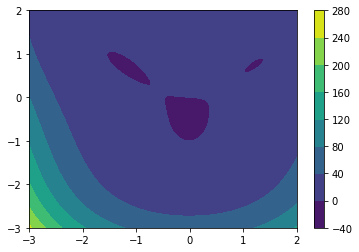

In [279]:
plt.figure()
X = np.linspace(-3, 2, size)
Y = np.linspace(-3, 2, size)
coord = np.array(np.meshgrid(X, Y))
F1_sample = F1(coord, p)
plt.contourf(coord[0],coord[1], F1_sample)
plt.colorbar()
plt.show()

In [298]:
np.shape(F1_sample)

(100, 100)

In [89]:
def gaussian(coord, x0 = 0, y0 = 0, sigma= 0.01):
  x = coord[0] - x0
  y = coord[1] - y0
  z = (1/(2*np.pi*sigma*sigma) * np.exp(-(x**2/(2*sigma**2)
     + y**2/(2*sigma**2))))
  return z

In [105]:
size = 200
X = np.linspace(-3, 2, size)
Y = np.linspace(-3, 3, size)
coord_flow = np.array(np.meshgrid(X, Y)).reshape(2, size**2)
flow = np.zeros([2, size**2])
p[5] = 0
p[0] = 0.1
p[1] = 1
for i in range(size**2):
    flow[:,i] = diffeq(0, coord_flow[:,i])

coord_flow = coord_flow.reshape(2, size, size)
flow = flow.reshape(2, size, size)
 

In [17]:
index = index_map(flow)
index_crit_point = return_crit_point(index)


In [18]:
stable = []
unstable = []
rest = []
for i in range(np.shape(index_crit_point)[0]):
    temp_crit_point = index_crit_point[i]
    eigval = crit_point_stability(temp_crit_point , flow)
    
    if np.prod(eigval)>0 and eigval[0]>0 :
        stable.append(temp_crit_point)
    elif np.prod(eigval)>0 and eigval[0]<0 :
        unstable.append(temp_crit_point)
    else: 
        rest.append(temp_crit_point)

stable = np.array(stable)
unstable = np.array(unstable)
rest = np.array(rest)

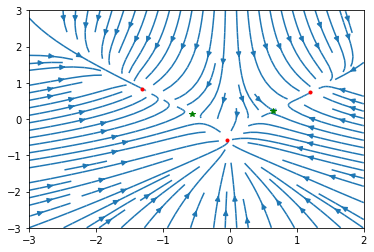

In [106]:
plt.figure()
x, y = index_to_coord(stable[:, 0], stable[:, 1], coord_flow)
plt.plot(x, y, 'r.')

# x, y = index_to_coord(unstable, coord)
# plt.plot(x, y, 'ro')

x, y = index_to_coord(rest[:, 0], rest[:, 1],  coord_flow)
plt.plot(x, y, 'g*')
plt.streamplot(coord_flow[0,:,:], coord_flow[1,:,:], flow[0,:,:], flow[1,:,:])
plt.show()

In [21]:
func = ODEFunc(2, 100, 1000, nlayer_M = 2, nlayer_V= 1, n_V=1)

torch_coord = torch.from_numpy(coord).float().to(device)
torch_coord = torch_coord.reshape(size**2,2)
torch_coord.requires_grad = True
torch_flow = torch.from_numpy(flow).float().to(device)
torch_flow.reshape(size**2,2)

# func.apply(init_weights)
params = list(func.potential_list.parameters())
lr = 0.01
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
min_loss = np.inf 

In [23]:
try:
    for i in range(1):

        x, y = index_to_coord(stable[0,0], stable[0,1] , coord)
        temp_gauss_pot = gaussian(coord, x, y, sigma = 0.3).reshape(size**2,1)
        temp_gauss_pot = torch.from_numpy(temp_gauss_pot).float().to(device)

        for itr in range(1, 10000):
            optimizer.zero_grad()
            diff = func.potential(i, 0, torch_coord)-temp_gauss_pot
            loss = (diff**2).sum()
            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item())

            display.clear_output()
            print('Iter: {}, MSE loss: {:.4f}'.format(itr, -loss_meter.avg))
        
            if loss_meter.avg <= min_loss:
                torch.save(func, 'min_func_Saez.pt')
                min_loss = loss_meter.avg
                print("min model_updated") 

except KeyboardInterrupt:

    print('Training complete after {} iters.'.format(itr))

Iter: 6774, MSE loss: -1167.1655
Training complete after 6775 iters.


In [291]:
class GaussianFunc(nn.Module):

  def __init__(self, dim=2, nhidden_P = 8):
    super(GaussianFunc, self).__init__()

    self.relu = nn.ReLU(inplace = True)
    self.elu = nn.ELU(inplace = True)
    self.th = nn.Tanh()
    self.sg = nn.Sigmoid()
    self.fc1 = nn.Linear(dim, nhidden_P)
    # self.fc2 = nn.Linear(nhidden_P, nhidden_P)
    # self.fc3 = nn.Linear(nhidden_P, nhidden_P)
    self.fc5 = nn.Linear(nhidden_P, nhidden_P, bias= False)
    self.fc6 = nn.Linear(nhidden_P, 1)
    self.temp = []
    


  def forward(self, x):
    out = self.fc1(x)
    out = torch.pow(out, 2)
    out = self.fc5(out)
    out = torch.exp(out)
    self.temp = out
    out = self.fc6(out)
    return out

  def forward(self, x):
    out = self.fc1(x)
    out = torch.pow(out, 2)
    out = self.fc5(out)
    out = torch.exp(out)
    self.temp = out
    out = self.fc6(out)
    return out

In [246]:
func.fc1.weight = torch.nn.Parameter(torch.eye(2))
func.fc5.weight = torch.nn.Parameter(torch.ones(1,2))
func.fc6.weight = torch.nn.Parameter(torch.tensor([2.]))

In [267]:
func.fc6.bias

Parameter containing:
tensor([-0.3691], requires_grad=True)

In [253]:
list(func.fc6.parameters())

[Parameter containing:
 tensor([2.], requires_grad=True),
 Parameter containing:
 tensor([-0.1539], requires_grad=True)]

In [260]:
func(torch.tensor([0., 0.]))

tensor([-0.1159], grad_fn=<AddBackward0>)

In [294]:
size = 100
X = np.linspace(-3, 2, size)
Y = np.linspace(-3, 3, size)
x, y = np.array(np.meshgrid(X, Y))

gaussian_mesh = gaussian([x,y], 0, 0, sigma = 0.3)
gaussian_mesh_flat = gaussian_mesh.reshape(-1,1)
samp_gaussian = torch.from_numpy(gaussian_mesh_flat).float().to(device)

In [292]:
func = GaussianFunc(2, 2)
params = list(func.parameters())
lr = 0.01
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()
pred_steps = 500

In [297]:
try:
    for itr in range(1, 100000):
        optimizer.zero_grad()
        pred = func(torch.Tensor(np.stack([x, y], -1).reshape(size * size, 2))) - samp_gaussian
        loss = ((pred - samp_gaussian)**2).sum()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        display.clear_output()
        print('Iter: {}, MSE loss: {:.4f}'.format(itr, -loss_meter.avg))

except KeyboardInterrupt:

    print('Training complete after {} iters.'.format(itr))

Training complete after 12496 iters.


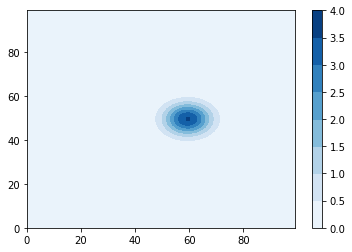

In [284]:
plt.figure()
h = func(torch.Tensor(np.stack([x, y], -1).reshape(size * size, 2))).reshape(size, size).detach().numpy()
plt.contourf(h, cmap='Blues')
plt.colorbar()
plt.show()

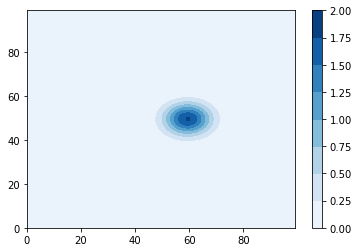

In [228]:
plt.contourf(samp_gaussian.reshape(size, size).detach().numpy(), cmap='Blues')
plt.colorbar()
plt.show()

In [82]:
np.shape(F1(coord, p))

(100, 100)

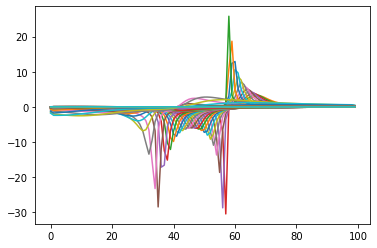

In [29]:
plt.figure()
for i in range (100):
    plt.plot(index[:,i])
plt.show()

In [108]:
im_x = h[0,:,:]
im_y = h[1,:,:]
int_x = copy.copy(im_x)
for i in range(1,100):
    int_x[i,:] = int_x[i, :] + int_x[i-1, :]

int_y = copy.copy(im_y)
for i in range(1,100):
    int_y[:,i] = int_y[:, i] + int_y[:, i-1]

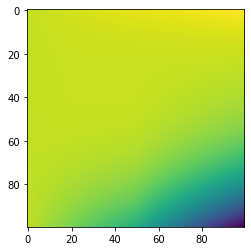

In [120]:
plt.imshow(int_y)

In [117]:
size = 100
interval_x = [-3, 2]
interval_y = [-3, 3]
x_peak, y_peak = index_to_coord(stable[0,0], stable[0,1] , coord_flow)

samp_coord = []
samp_eq = []
xinterval_len = interval_x[1]-interval_x[0]
yinterval_len = interval_y[1]-interval_y[0]

for i in range(0, size**2):
    x = xinterval_len*np.random.sample()+interval_x[0]
    y = yinterval_len*np.random.sample()+interval_y[0]
    coord = [x, y]
    samp_coord.append(coord)

    f = gaussian(coord, x_peak, y_peak, sigma = 0.3)
    samp_eq.append(f)

samp_coord_numpy = np.stack(samp_coord, axis=0)
samp_Gaussian_numpy = np.stack(samp_eq, axis=0)

samp_coord = torch.from_numpy(samp_coord_numpy).float().to(device)
samp_coord.requires_grad = True

samp_Gaussian = torch.from_numpy(samp_Gaussian_numpy).float().to(device)